In [1]:
###加载数据


import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 设置绘图风格和中文显示
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# --- 加载我们上一阶段准备好的最终数据 ---
try:
    # 请确保文件名与您保存的文件一致
    # 【核心修正】在这里添加了 encoding='utf-8-sig'
    data_path = r"E:\A智网\电量预测数据\lightgbm模型\133个行业电量气象对齐数据.csv"
    df = pd.read_csv(data_path, parse_dates=['date'], encoding='utf-8-sig')
    print("数据加载成功！")
    print(df.head())
    
except FileNotFoundError:
    print(f"错误：文件未找到 {data_path}，请检查路径。")
    df = pd.DataFrame()
except UnicodeDecodeError:
    # 如果'utf-8-sig'也不行，说明文件可能被意外地用GBK编码覆盖了
    print("使用 'utf-8-sig' 编码失败，这很奇怪。正在尝试 'gbk' 作为备用方案...")
    try:
        df = pd.read_csv(data_path, parse_dates=['date'], encoding='gbk')
        print("数据加载成功！")
        print(df.head())
    except Exception as e:
        print(f"尝试所有编码后依然加载失败: {e}")
        df = pd.DataFrame()
except Exception as e:
    print(f"加载数据时发生未知错误: {e}")
    df = pd.DataFrame()

使用 'utf-8-sig' 编码失败，这很奇怪。正在尝试 'gbk' 作为备用方案...
数据加载成功！
        行业名称       date    load_MWh  temp_mean  temp_max  temp_min  temp_std  \
0      客户用电量 2023-01-01  56822.2209      6.883     8.776     5.495      1.09   
1  A、全行业用电合计 2023-01-01  39712.4177      6.883     8.776     5.495      1.09   
2       第一产业 2023-01-01    811.9297      6.883     8.776     5.495      1.09   
3       第二产业 2023-01-01  25598.1050      6.883     8.776     5.495      1.09   
4       第三产业 2023-01-01  13302.3830      6.883     8.776     5.495      1.09   

   temp_range  
0       3.281  
1       3.281  
2       3.281  
3       3.281  
4       3.281  


In [26]:
#导入我们需要的库
#特征工程


from chinese_calendar import is_workday, is_holiday

def create_panel_features_with_holidays(df):
    """
    为面板数据创建特征 (包含节假日特征)
    """
    df = df.copy()
    
    # 确保数据按行业和日期排序
    df = df.sort_values(by=['行业名称', 'date']).reset_index(drop=True)
    
    # --- 1. 时间特征 ---
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    
    # --- 【核心新增】创建节假日特征 ---
    # is_holiday() 返回 True / False
    # is_workday() 对于调休的工作日也返回 True
    
    # a) 是否为法定节假日 (如国庆节当天)
    df['is_holiday'] = df['date'].apply(is_holiday).astype(int)
    
    # b) 是否为周末 (正常的周六日)
    df['is_weekend_norm'] = (df['date'].dt.dayofweek >= 5).astype(int)
    
    # c) 是否为调休的工作日 (本应是周末但需要上班)
    # is_workday返回True, 且 dayofweek >= 5 (是周末)
    df['is_adj_workday'] = df.apply(lambda row: 1 if is_workday(row['date']) and row['dayofweek'] >= 5 else 0, axis=1)

    # d) 最终的“休息日”特征：是节假日，或者是“正常的”周末（排除了调休）
    df['is_offday'] = df.apply(lambda row: 1 if row['is_holiday'] == 1 or (row['is_weekend_norm'] == 1 and row['is_adj_workday'] == 0) else 0, axis=1)

    print("节假日特征创建预览：")
    # 找一个包含节假日的日期范围来检查
    holiday_check_df = df[df['date'].between('2024-04-28', '2024-05-06')].drop_duplicates(subset=['date'])
    print(holiday_check_df[['date', 'dayofweek', 'is_holiday', 'is_weekend_norm', 'is_adj_workday', 'is_offday']])
    
    # --- 2. 滞后特征 (Lag Features) ---
    lags = [1, 2, 7, 14]
    for lag in lags:
        df[f'load_lag_{lag}'] = df.groupby('行业名称')['load_MWh'].shift(lag)
        
    # --- 3. 窗口特征 (Rolling Window Features) ---
    df['rolling_mean_7'] = df.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).mean()
    df['rolling_std_7'] = df.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).std()
    
    # --- 5. 【核心新增】高级差异/比率特征 ---
    print("正在创建高级差异/比率特征...")
    
    # a) 昨天的电量与上周同一天电量的差异
    #    这个特征能直接告诉模型“周同比”的变化趋势
    df['load_diff_1_7'] = df['load_lag_1'] - df['load_lag_7']
    
    # b) 昨天的电量与过去7天平均值的差异比率
    #    这个特征能量化“昨天”是否是一个反常的高点或低点
    #    + 1e-6 是为了防止除以0的错误
    df['load_ratio_1_roll7'] = (df['load_lag_1'] / (df['rolling_mean_7'] + 1e-6)) -1

    print("高级特征创建完成！")


    # --- 6. 行业本身作为特征 ---
    df['行业名称'] = df['行业名称'].astype('category')
    
    # 【清理】删除我们用于计算的中间特征
    df = df.drop(['is_weekend_norm', 'is_adj_workday'], axis=1)
    
    return df

# --- 调用新的特征工程函数 ---
if not df.empty:
    print("\n开始进行特征工程 (包含节假日特征)...")
    df_featured = create_panel_features_with_holidays(df)
    
    # 删除因创建滞后特征而产生的空值行
    df_featured = df_featured.dropna()
    
    print("\n特征工程完成！数据预览：")
    print(df_featured.head())
    print("\n特征列数据类型：")
    df_featured.info()


开始进行特征工程 (包含节假日特征)...
节假日特征创建预览：
          date  dayofweek  is_holiday  is_weekend_norm  is_adj_workday  \
483 2024-04-28          6           0                1               1   
484 2024-04-29          0           0                0               0   
485 2024-04-30          1           0                0               0   
486 2024-05-01          2           1                0               0   
487 2024-05-02          3           1                0               0   
488 2024-05-03          4           1                0               0   
489 2024-05-04          5           1                1               0   
490 2024-05-05          6           1                1               0   
491 2024-05-06          0           0                0               0   

     is_offday  
483          0  
484          0  
485          0  
486          1  
487          1  
488          1  
489          1  
490          1  
491          0  
正在创建高级差异/比率特征...
高级特征创建完成！

特征工程完成！数据预览：
           行业名

In [28]:
##模型分层

# --- 步骤：模型分层 (使用我们新决定的阈值) ---

print("--- 开始进行模型分层 ---")

# 1. 计算每个行业的日均用电量
#    注意: df_featured 是已经完成特征工程的数据
industry_avg_load = df_featured.groupby('行业名称')['load_MWh'].mean().to_frame('avg_load')

# 2. 【核心修改】根据我们分析得出的新阈值来定义行业层级
def assign_tier(avg_load):
    if avg_load >= 1000: # 大于等于1000的为大行业
        return '大行业'
    elif avg_load < 100:  # 小于100的为小行业
        return '小行业'
    else:                 # 其他为中行业
        return '中行业'

industry_avg_load['tier'] = industry_avg_load['avg_load'].apply(assign_tier)

print("各行业层级划分预览：")
print(industry_avg_load.head())

# 3. 将层级信息合并回主数据集
df_tiered = df_featured.merge(industry_avg_load[['tier']], on='行业名称', how='left')

# 4. 根据层级，将数据集拆分为多个子集
df_large = df_tiered[df_tiered['tier'] == '大行业'].copy()
df_medium = df_tiered[df_tiered['tier'] == '中行业'].copy()
df_small = df_tiered[df_tiered['tier'] == '小行业'].copy()

print(f"\n数据集拆分完成：")
print(f"  大行业数量: {df_large['行业名称'].nunique()}, 数据点: {len(df_large)}")
print(f"  中行业数量: {df_medium['行业名称'].nunique()}, 数据点: {len(df_medium)}")
print(f"  小行业数量: {df_small['行业名称'].nunique()}, 数据点: {len(df_small)}")



--- 开始进行模型分层 ---
各行业层级划分预览：
         avg_load tier
行业名称                  
  其中：排灌    342.35  中行业
1.农业       519.57  中行业
2.林业         8.74  小行业
3.畜牧业      412.89  中行业
4.渔业       141.65  中行业

数据集拆分完成：
  大行业数量: 34, 数据点: 30532
  中行业数量: 64, 数据点: 57472
  小行业数量: 36, 数据点: 32328


C:\Users\Joe-h\AppData\Local\Temp\ipykernel_37432\592002644.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_avg_load = df_featured.groupby('行业名称')['load_MWh'].mean().to_frame('avg_load')


In [29]:
import optuna

# --- 步骤：为三个分层模型分别进行超参数调优 ---

# 准备一个字典来存放我们的数据集
data_tiers = {
    '大行业': df_large,
    '中行业': df_medium,
    '小行业': df_small
}

# 准备一个字典来存放每个模型的最优参数
best_params_per_tier = {}

print("\n" + "="*50)
print("      开始为三个层级的模型进行自动化超参数调优")
print("="*50)

# 循环为每个层级的数据进行调优
for tier_name, df_tier in data_tiers.items():
    if df_tier.empty:
        print(f"\n--- 跳过【{tier_name}】模型，因为该层级没有数据 ---")
        continue

    print(f"\n--- 正在为【{tier_name}】模型寻找最优参数 ---")
    
    # 1. 数据划分 (使用更早的数据作为验证集，以留出最终的测试集)
    #    我们用倒数31-60天的数据做验证集，最后30天做最终测试
    val_date_start = df_tier['date'].max() - pd.DateOffset(days=60)
    val_date_end = df_tier['date'].max() - pd.DateOffset(days=31)
    
    train = df_tier[df_tier['date'] < val_date_start].copy()
    val = df_tier[(df_tier['date'] >= val_date_start) & (df_tier['date'] <= val_date_end)].copy()

    FEATURES = [col for col in df_tier.columns if col not in ['date', 'load_MWh', 'tier']]
    TARGET = 'load_MWh'
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_val, y_val = val[FEATURES], val[TARGET]

    # 2. 定义Optuna的目标函数
    def objective(trial):
        # 定义我们要调优的参数搜索空间
        params = {
            'objective': 'regression_l1',
            'metric': 'l1', # l1-mae
            'n_estimators': 2000, # 先用一个固定的较大值，早停会自动找到最佳值
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1, # 关闭啰嗦的日志
            # --- 以下是我们要优化的超参数 ---
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        }
        
        # 训练模型
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)],
                  categorical_feature=['行业名称'])
        
        # 预测并计算在验证集上的MAE
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        
        return mae

    # 3. 创建并运行Optuna研究
    # storage=None 表示结果存在内存里, sampler=TPESampler() 是默认的高效采样器
    study = optuna.create_study(direction='minimize') 
    # n_trials=50 表示我们会尝试50组不同的参数组合
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    # 4. 保存并打印找到的最佳参数
    best_params = study.best_params
    best_params_per_tier[tier_name] = best_params
    
    print(f"【{tier_name}】模型调优完成！")
    print(f"  最佳验证集 MAE: {study.best_value:.2f}")
    print(f"  找到的最佳参数: {best_params}")

print("\n" + "="*50)
print("      所有模型的超参数调优均已完成！")
print("="*50)
print("最终找到的各层级最优参数为：")
print(best_params_per_tier)

[I 2025-09-02 18:02:38,653] A new study created in memory with name: no-name-51d67b03-3fdc-4a45-8bc7-8a2a56e108dd



      开始为三个层级的模型进行自动化超参数调优

--- 正在为【大行业】模型寻找最优参数 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-02 18:02:41,108] Trial 0 finished with value: 287.0157654104862 and parameters: {'learning_rate': 0.06007013232821779, 'num_leaves': 236, 'max_depth': 9, 'min_child_samples': 65, 'feature_fraction': 0.5381409591620099, 'bagging_fraction': 0.671153101965001, 'bagging_freq': 3, 'lambda_l1': 0.005624893546942809, 'lambda_l2': 0.002565120991551813}. Best is trial 0 with value: 287.0157654104862.
[I 2025-09-02 18:02:42,467] Trial 1 finished with value: 311.6696748678612 and parameters: {'learning_rate': 0.26699782245922943, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 60, 'feature_fraction': 0.7902090062493601, 'bagging_fraction': 0.8052124025318466, 'bagging_freq': 3, 'lambda_l1': 5.8431705648673945e-06, 'lambda_l2': 2.6475217002381195e-08}. Best is trial 0 with value: 287.0157654104862.
[I 2025-09-02 18:02:45,278] Trial 2 finished with value: 283.8418864249645 and parameters: {'learning_rate': 0.054705097404471395, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples

[I 2025-09-02 18:04:49,753] A new study created in memory with name: no-name-045a9baf-2eed-4108-97e7-cfca7ade98dd


[I 2025-09-02 18:04:49,733] Trial 49 finished with value: 283.52849812583014 and parameters: {'learning_rate': 0.03440383110460914, 'num_leaves': 175, 'max_depth': 12, 'min_child_samples': 69, 'feature_fraction': 0.9920052888335705, 'bagging_fraction': 0.6567036081667401, 'bagging_freq': 3, 'lambda_l1': 3.022680308890135e-06, 'lambda_l2': 7.225963728340049e-06}. Best is trial 48 with value: 273.88323079512446.
【大行业】模型调优完成！
  最佳验证集 MAE: 273.88
  找到的最佳参数: {'learning_rate': 0.0333344132085205, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 74, 'feature_fraction': 0.9940956691378667, 'bagging_fraction': 0.6724332274627274, 'bagging_freq': 3, 'lambda_l1': 4.2278628549432296e-06, 'lambda_l2': 0.00031808945561824937}

--- 正在为【中行业】模型寻找最优参数 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-02 18:04:54,385] Trial 0 finished with value: 19.5412003103449 and parameters: {'learning_rate': 0.06181657048846255, 'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 51, 'feature_fraction': 0.8713658821367448, 'bagging_fraction': 0.7630362571294305, 'bagging_freq': 1, 'lambda_l1': 0.0018581075684760964, 'lambda_l2': 6.294909191779147e-07}. Best is trial 0 with value: 19.5412003103449.
[I 2025-09-02 18:04:57,758] Trial 1 finished with value: 21.604911974560498 and parameters: {'learning_rate': 0.016166046159439403, 'num_leaves': 170, 'max_depth': 4, 'min_child_samples': 27, 'feature_fraction': 0.7839610955820815, 'bagging_fraction': 0.908796246236272, 'bagging_freq': 2, 'lambda_l1': 4.599138409882791e-08, 'lambda_l2': 0.0001404908558200726}. Best is trial 0 with value: 19.5412003103449.
[I 2025-09-02 18:05:00,513] Trial 2 finished with value: 20.596215186054096 and parameters: {'learning_rate': 0.20219258013327415, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples'

[I 2025-09-02 18:10:27,120] A new study created in memory with name: no-name-47e9d977-4091-4935-b51e-4806a90ee816


[I 2025-09-02 18:10:27,102] Trial 49 finished with value: 19.808688736735682 and parameters: {'learning_rate': 0.017207427138047005, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 85, 'feature_fraction': 0.8726195852928721, 'bagging_fraction': 0.5509262476994796, 'bagging_freq': 4, 'lambda_l1': 0.09015030952014198, 'lambda_l2': 0.002325052877132014}. Best is trial 10 with value: 18.6939080314066.
【中行业】模型调优完成！
  最佳验证集 MAE: 18.69
  找到的最佳参数: {'learning_rate': 0.031660776595989384, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 65, 'feature_fraction': 0.9990567449226713, 'bagging_fraction': 0.7828085539715408, 'bagging_freq': 1, 'lambda_l1': 7.263066273094625, 'lambda_l2': 0.0015989280210986856}

--- 正在为【小行业】模型寻找最优参数 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-02 18:10:28,689] Trial 0 finished with value: 2.4043680635258533 and parameters: {'learning_rate': 0.0680159718781989, 'num_leaves': 43, 'max_depth': 5, 'min_child_samples': 33, 'feature_fraction': 0.8982107446096319, 'bagging_fraction': 0.41215196179719993, 'bagging_freq': 6, 'lambda_l1': 5.435351953492834e-06, 'lambda_l2': 7.891032429528648e-07}. Best is trial 0 with value: 2.4043680635258533.
[I 2025-09-02 18:10:31,704] Trial 1 finished with value: 2.513505632680271 and parameters: {'learning_rate': 0.013487782494212572, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 13, 'feature_fraction': 0.7619759483125355, 'bagging_fraction': 0.803172990231303, 'bagging_freq': 5, 'lambda_l1': 2.5333546106573628e-05, 'lambda_l2': 0.0006846434551490366}. Best is trial 0 with value: 2.4043680635258533.
[I 2025-09-02 18:10:38,260] Trial 2 finished with value: 2.3585428422445536 and parameters: {'learning_rate': 0.01345384647342311, 'num_leaves': 107, 'max_depth': 11, 'min_child_s

In [32]:
# --- 最终步骤：使用最优参数重新训练模型并进行最终评估 ---

# 1. 加载我们刚刚找到的最优参数
#    (为了代码的独立性，我将您提供的结果直接复制到这里)
best_params_per_tier = {
    '大行业': {'learning_rate': 0.0333344132085205, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 74, 'feature_fraction': 0.9940956691378667, 'bagging_fraction': 0.6724332274627274, 'bagging_freq': 3, 'lambda_l1': 4.2278628549432296e-06, 'lambda_l2': 0.00031808945561824937},
    '中行业': {'learning_rate': 0.031660776595989384, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 65, 'feature_fraction': 0.9990567449226713, 'bagging_fraction': 0.7828085539715408, 'bagging_freq': 1, 'lambda_l1': 7.263066273094625, 'lambda_l2': 0.0015989280210986856},
    '小行业': {'learning_rate': 0.05813350836488134, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 94, 'feature_fraction': 0.5812392249864817, 'bagging_fraction': 0.7707098775828991, 'bagging_freq': 6, 'lambda_l1': 0.6831740724793995, 'lambda_l2': 5.05154679808148e-07}
}

# 准备字典来存放最终模型和预测结果
final_models = {}
final_predictions = []

print("\n" + "="*50)
print("      使用调优后的最优参数进行最终训练与评估")
print("="*50)

for tier_name, df_tier in data_tiers.items():
    if df_tier.empty: continue
    print(f"\n--- 正在处理【{tier_name}】模型 (最终训练) ---")
    
    # 2. 【关键】这次我们在全部数据上划分，使用最终的测试集
    split_date = df_tier['date'].max() - pd.DateOffset(days=30)
    train = df_tier[df_tier['date'] <= split_date].copy()
    test = df_tier[df_tier['date'] > split_date].copy()
    
    FEATURES = [col for col in df_tier.columns if col not in ['date', 'load_MWh', 'tier']]
    TARGET = 'load_MWh'
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    # 3. 【核心】加载该层级的最优参数
    params = best_params_per_tier[tier_name]
    # 添加一些固定参数
    params['objective'] = 'regression_l1'
    params['random_state'] = 42
    params['n_jobs'] = -1
    params['n_estimators'] = 5000 # 仍然使用较大的n_estimators和早停

    model = lgb.LGBMRegressor(**params)
    
    print(f"开始使用最优参数训练【{tier_name}】模型...")
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(200, verbose=False)],
              categorical_feature=['行业名称'])
              
    final_models[tier_name] = model
    print(f"【{tier_name}】模型训练完成。最佳迭代次数: {model.best_iteration_}")
    
    test['prediction'] = model.predict(X_test)
    final_predictions.append(test)
    
# 4. 合并所有预测结果，进行总体性能评估
if final_predictions:
    final_test_df_tuned = pd.concat(final_predictions)
    overall_mae_tuned = mean_absolute_error(final_test_df_tuned[TARGET], final_test_df_tuned['prediction'])
    overall_rmse_tuned = np.sqrt(mean_squared_error(final_test_df_tuned[TARGET], final_test_df_tuned['prediction']))

    print("\n" + "="*50)
    print("      【最终版】调优后模型总体性能评估")
    print("="*50)
    print(f"  调优前 MAE: 92.34")
    print(f"  调优后整体 MAE: {overall_mae_tuned:,.2f}")
    print(f"  调优后整体 RMSE: {overall_rmse_tuned:,.2f}")
else:
    print("未能成功训练任何模型。")

# 5. (可选) 您可以再次使用重点行业评估代码块
#    只需将输入DataFrame改为 `final_test_df_tuned`


      使用调优后的最优参数进行最终训练与评估

--- 正在处理【大行业】模型 (最终训练) ---
开始使用最优参数训练【大行业】模型...
【大行业】模型训练完成。最佳迭代次数: 2324

--- 正在处理【中行业】模型 (最终训练) ---
开始使用最优参数训练【中行业】模型...
【中行业】模型训练完成。最佳迭代次数: 4200

--- 正在处理【小行业】模型 (最终训练) ---
开始使用最优参数训练【小行业】模型...
【小行业】模型训练完成。最佳迭代次数: 3000

      【最终版】调优后模型总体性能评估
  调优前 MAE: 92.34
  调优后整体 MAE: 92.13
  调优后整体 RMSE: 342.37


In [31]:
# --- 步骤：为三个层级的行业分别训练和评估模型 (修正版) ---

# 准备一个字典来存放我们的数据集和训练好的模型
data_tiers = {
    '大行业': df_large,
    '中行业': df_medium,
    '小行业': df_small
}

models = {}
all_predictions = [] # 用来收集每个模型的测试集预测结果

print("\n" + "="*50)
print("      开始为三个层级的行业分别训练模型")
print("="*50)

for tier_name, df_tier in data_tiers.items():
    
    if df_tier.empty:
        print(f"\n--- 跳过【{tier_name}】模型，因为该层级没有数据 ---")
        continue

    print(f"\n--- 正在处理【{tier_name}】模型 ---")
    
    if len(df_tier['date'].unique()) <= 30:
        print(f"警告：【{tier_name}】的数据量过少，无法划分为训练集和测试集，已跳过。")
        continue

    split_date = df_tier['date'].max() - pd.DateOffset(days=30)
    train = df_tier[df_tier['date'] <= split_date].copy()
    test = df_tier[df_tier['date'] > split_date].copy()
    
    FEATURES = [col for col in df_tier.columns if col not in ['date', 'load_MWh', 'tier']]
    TARGET = 'load_MWh'
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]
    
    reg = lgb.LGBMRegressor(
        objective='regression_l1',
        n_estimators=3500,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1
    )
    
    print(f"开始训练【{tier_name}】模型...")
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='mae',
            callbacks=[lgb.early_stopping(200, verbose=False)],
            categorical_feature=['行业名称'])
            
    models[tier_name] = reg
    print(f"【{tier_name}】模型训练完成。最佳迭代次数: {reg.best_iteration_}")
    
    test['prediction'] = reg.predict(X_test)
    all_predictions.append(test)
    
    # 【核心修正】在这里使用 test['prediction'] 来引用预测值列
    mae = mean_absolute_error(test[TARGET], test['prediction'])
    rmse = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
    
    print(f"  在【{tier_name}】测试集上的 MAE: {mae:,.2f}")
    print(f"  在【{tier_name}】测试集上的 RMSE: {rmse:,.2f}")

if all_predictions:
    final_test_df = pd.concat(all_predictions)
    overall_mae = mean_absolute_error(final_test_df[TARGET], final_test_df['prediction'])
    overall_rmse = np.sqrt(mean_squared_error(final_test_df[TARGET], final_test_df['prediction']))

    print("\n" + "="*50)
    print("      模型分层策略【总体性能评估】")
    print("="*50)
    print(f"  整体平均绝对误差 (MAE): {overall_mae:,.2f}")
    print(f"  整体均方根误差 (RMSE): {overall_rmse:,.2f}")

else:
    print("\n未能成功训练任何模型，无法进行总体评估。")


      开始为三个层级的行业分别训练模型

--- 正在处理【大行业】模型 ---
开始训练【大行业】模型...
【大行业】模型训练完成。最佳迭代次数: 1064
  在【大行业】测试集上的 MAE: 340.22
  在【大行业】测试集上的 RMSE: 706.85

--- 正在处理【中行业】模型 ---
开始训练【中行业】模型...
【中行业】模型训练完成。最佳迭代次数: 3496
  在【中行业】测试集上的 MAE: 19.81
  在【中行业】测试集上的 RMSE: 45.78

--- 正在处理【小行业】模型 ---
开始训练【小行业】模型...
【小行业】模型训练完成。最佳迭代次数: 2619
  在【小行业】测试集上的 MAE: 2.00
  在【小行业】测试集上的 RMSE: 4.12

      模型分层策略【总体性能评估】
  整体平均绝对误差 (MAE): 96.33
  整体均方根误差 (RMSE): 357.46



      重点行业性能评估报告 (分层模型版)
                所属模型层级  平均绝对误差 (MAE)  均方根误差 (RMSE) 平均绝对百分比误差 (MAPE)     日均用电量 MAE占日均比
行业名称                                                                                 
客户用电量              大行业      2,177.94      2,650.42            3.01% 71,420.28   3.05%
    第二产业           大行业        790.31        990.42            2.18% 36,556.22   2.16%
B、城乡居民生活用电合计       大行业        883.77      1,084.69            6.22% 14,087.37   6.27%
14.化学原料和化学制品制造业    大行业        109.76        142.58            2.02%  5,389.35   2.04%
15.医药制造业           中行业         25.88         32.41            2.82%    939.97   2.75%
18.非金属矿物制品业        大行业        101.78        144.17            2.89%  3,593.53   2.83%
19.黑色金属冶炼和压延加工业    大行业         98.82        121.19            4.17%  2,412.43   4.10%
20.有色金属冶炼和压延加工业    中行业         12.36         16.57            2.01%    626.95   1.97%
24.汽车制造业           大行业         88.25        119.33            6.34%  1,573.14   5.61%
26.电气机械和器材制造业      大行业      

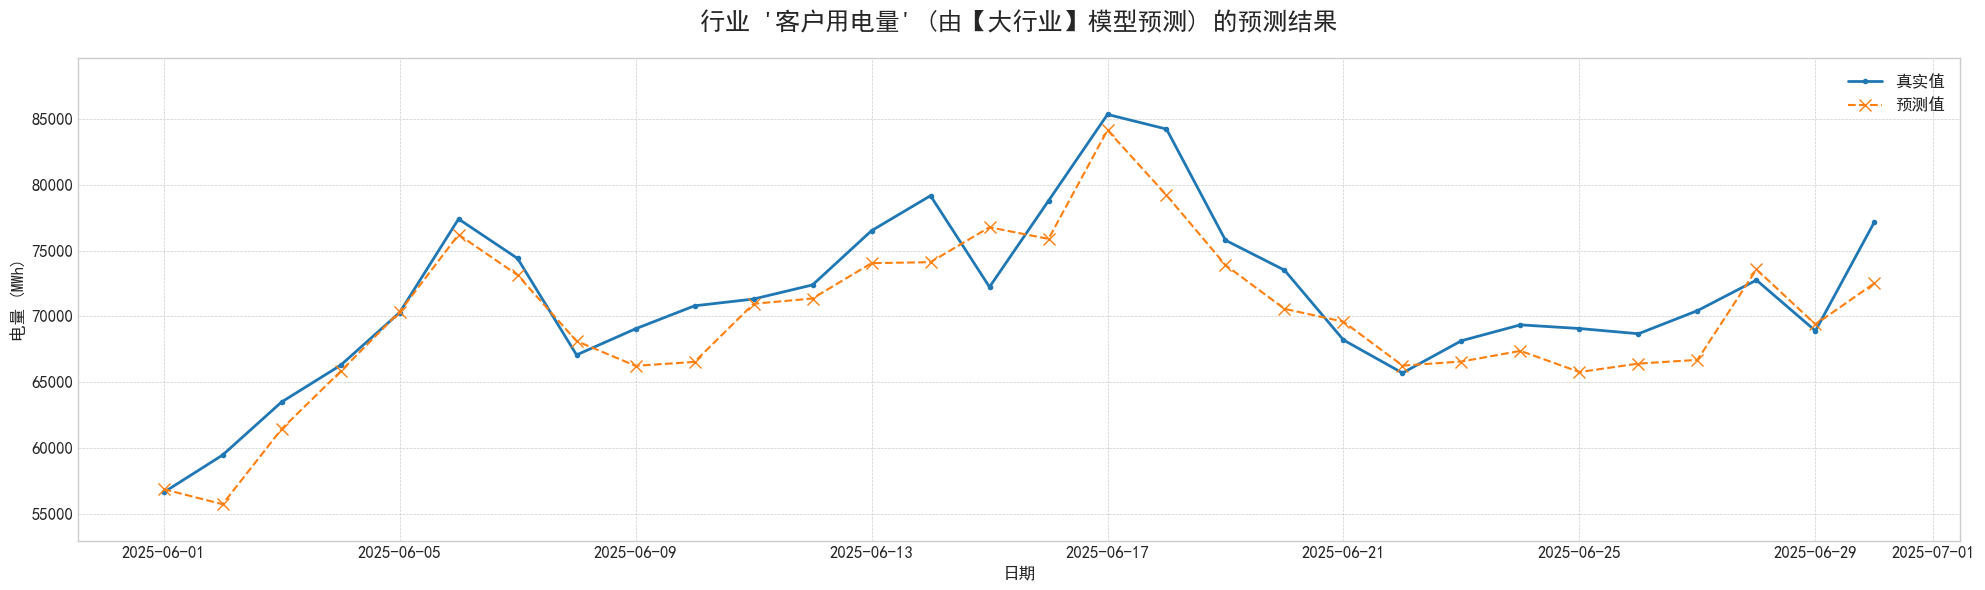

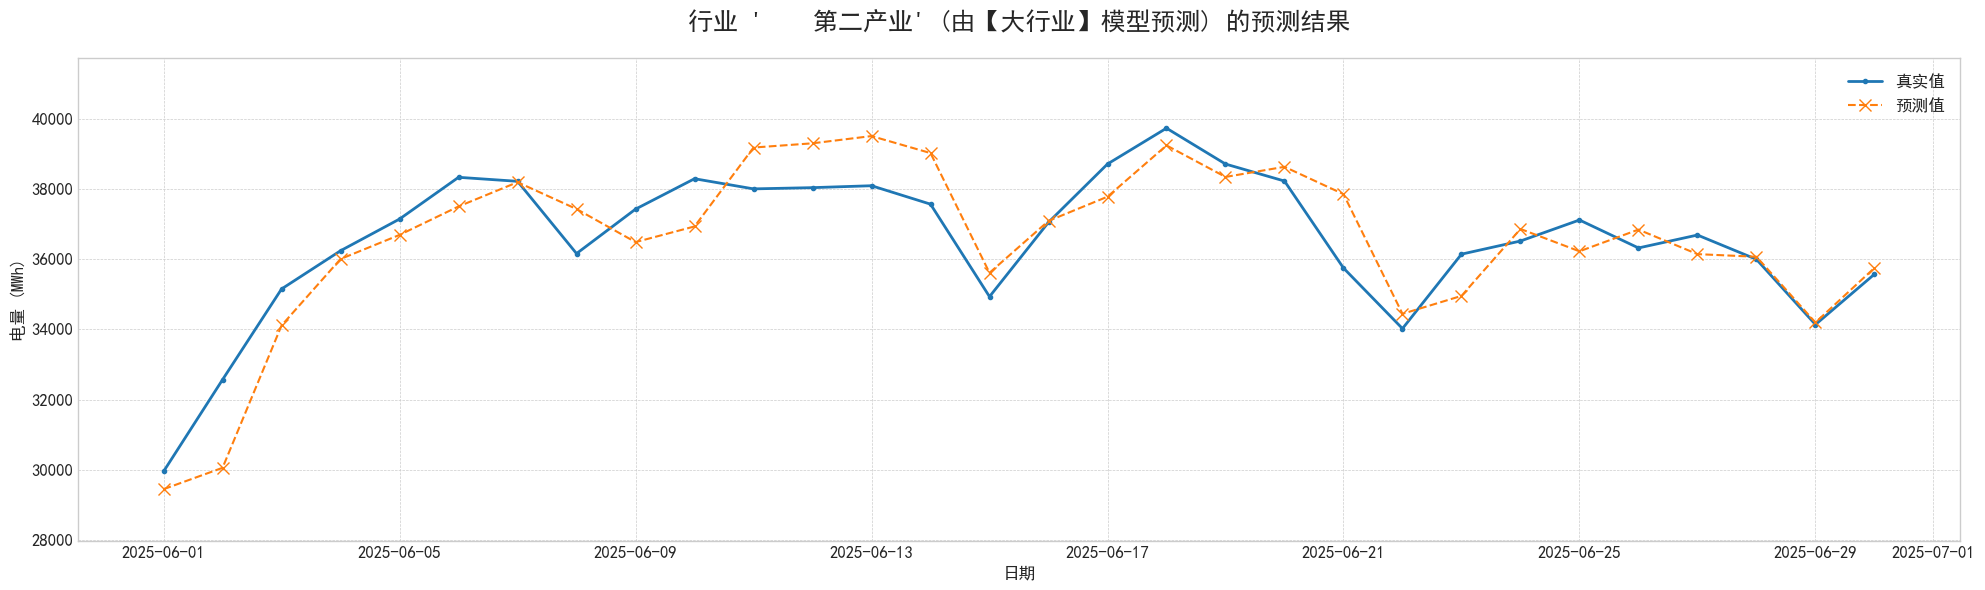

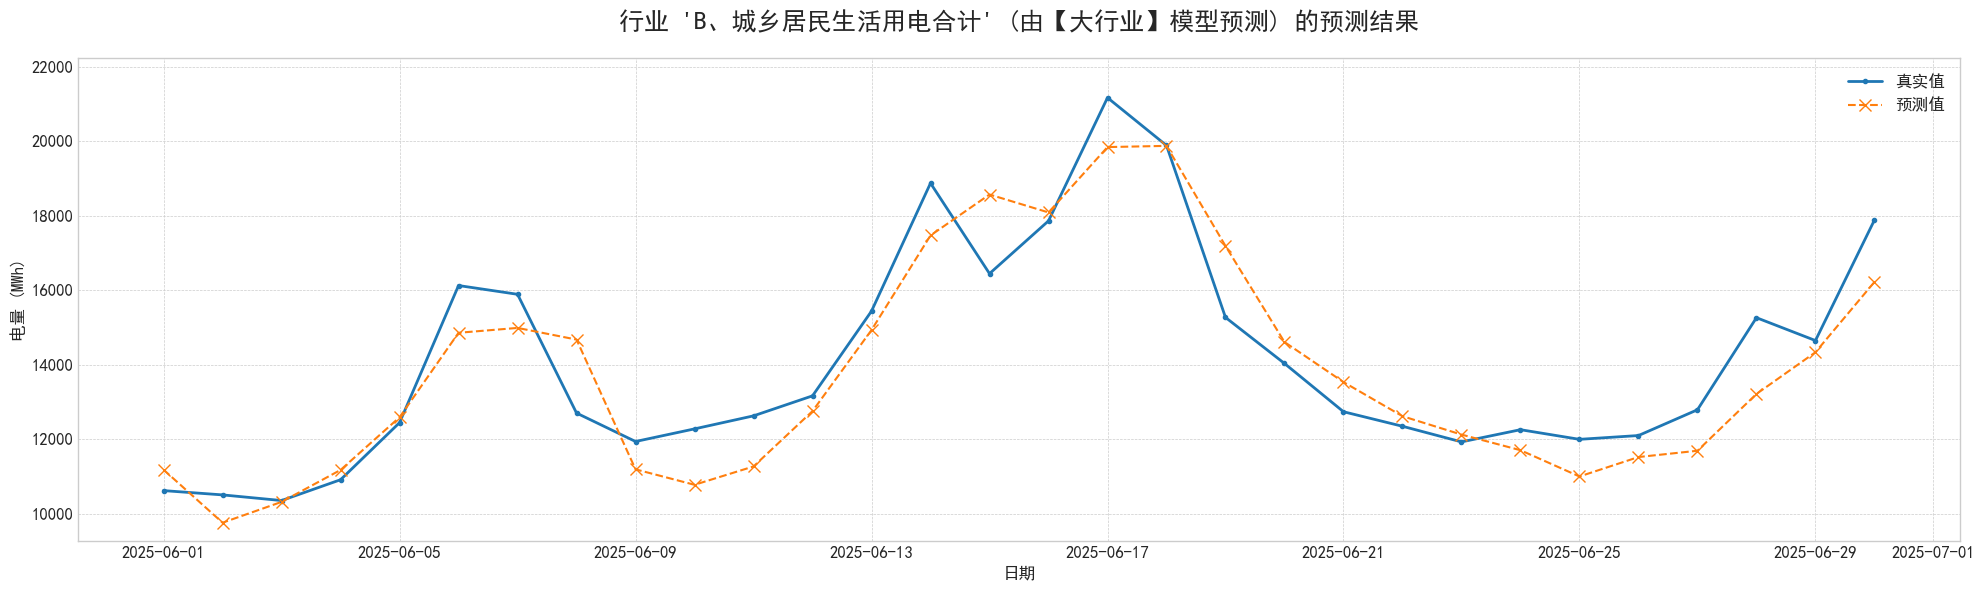

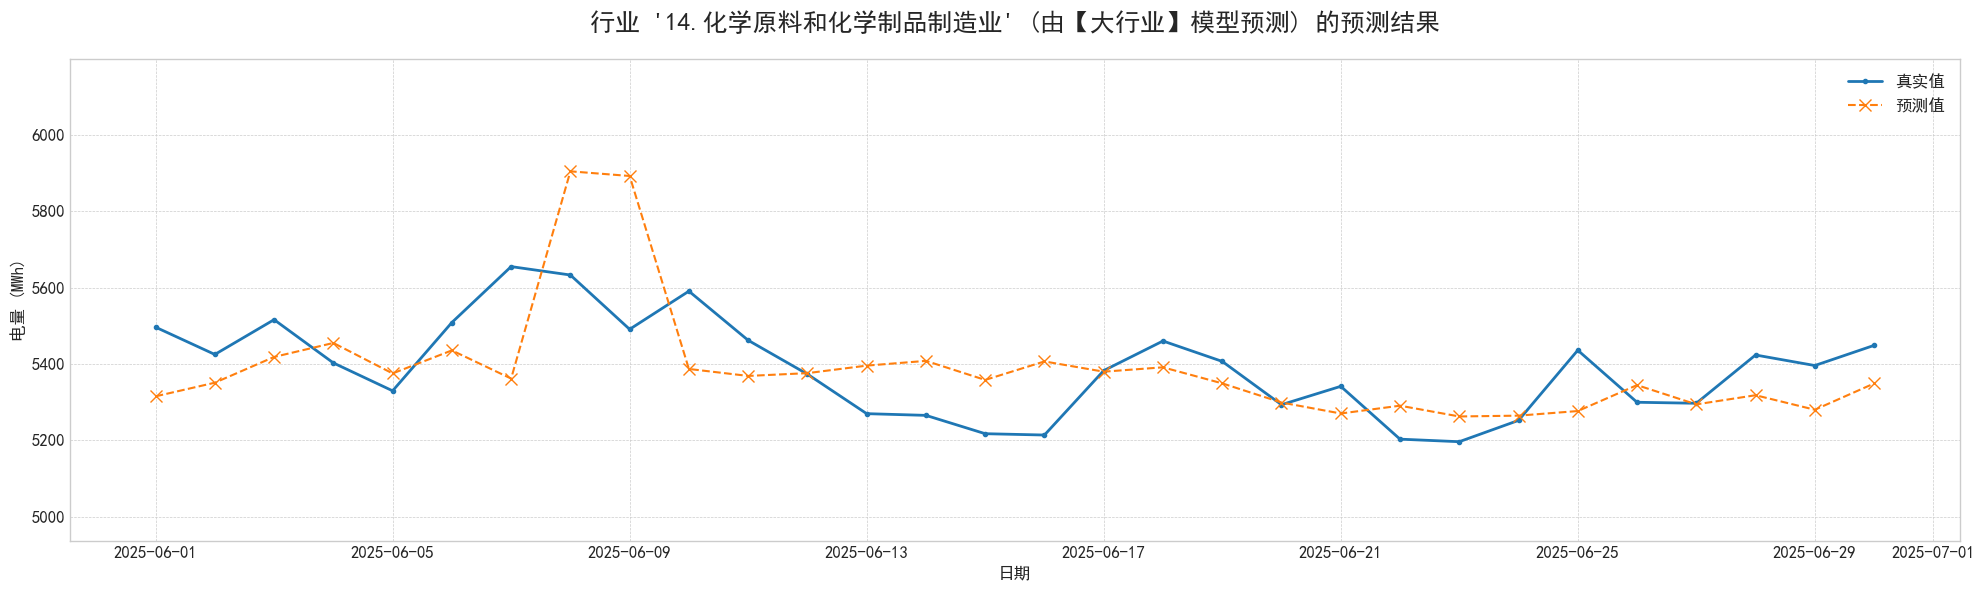

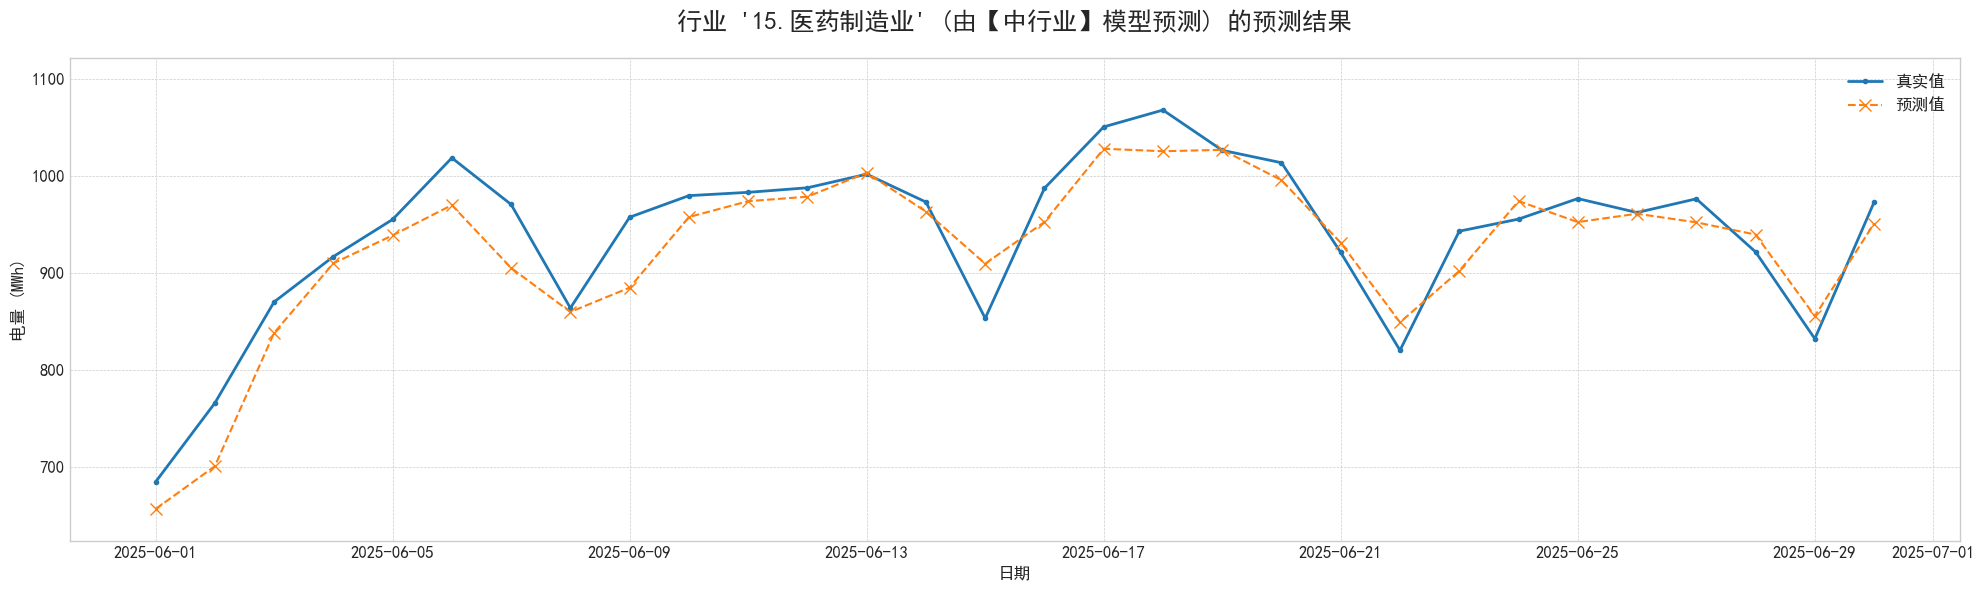

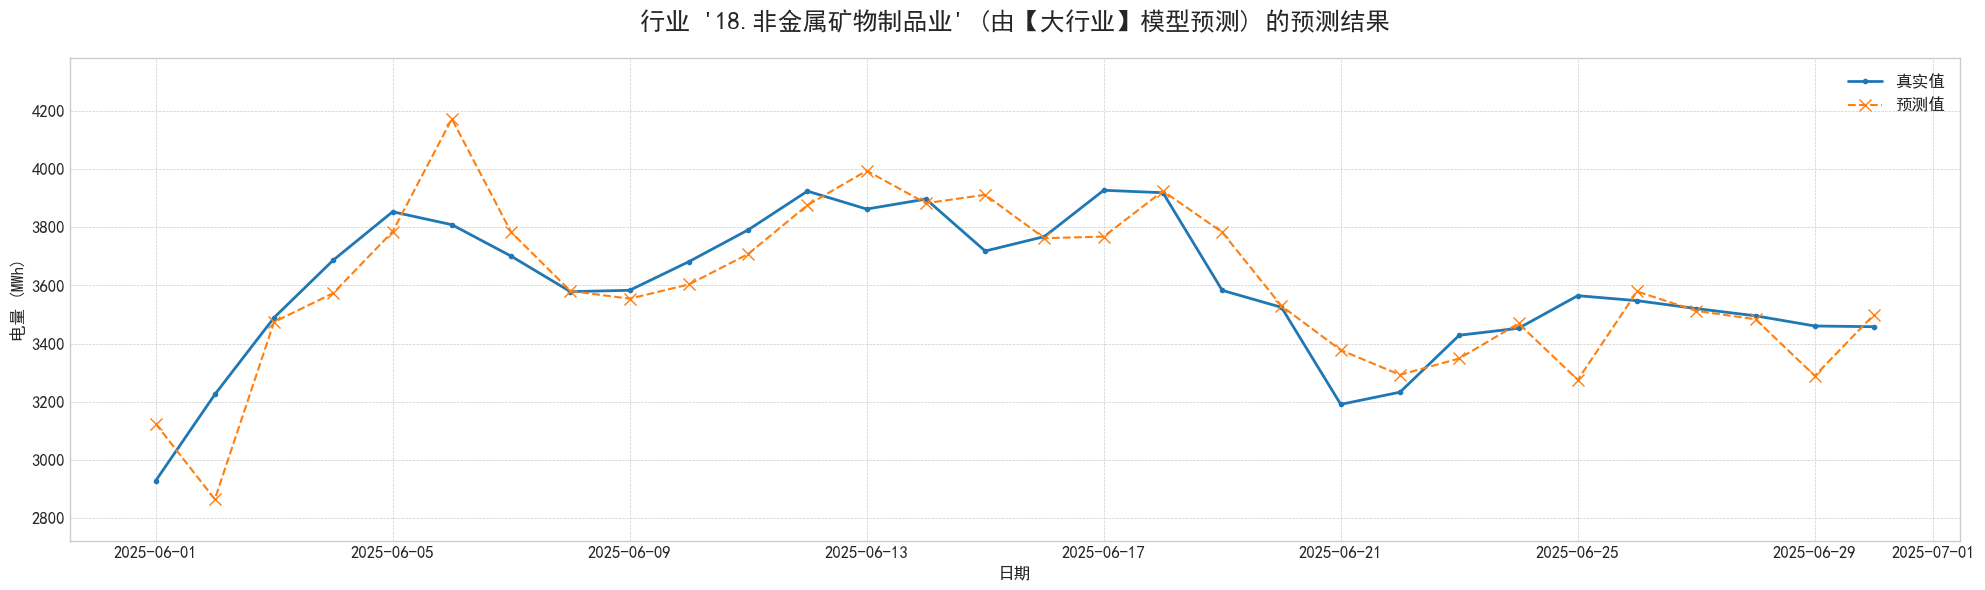

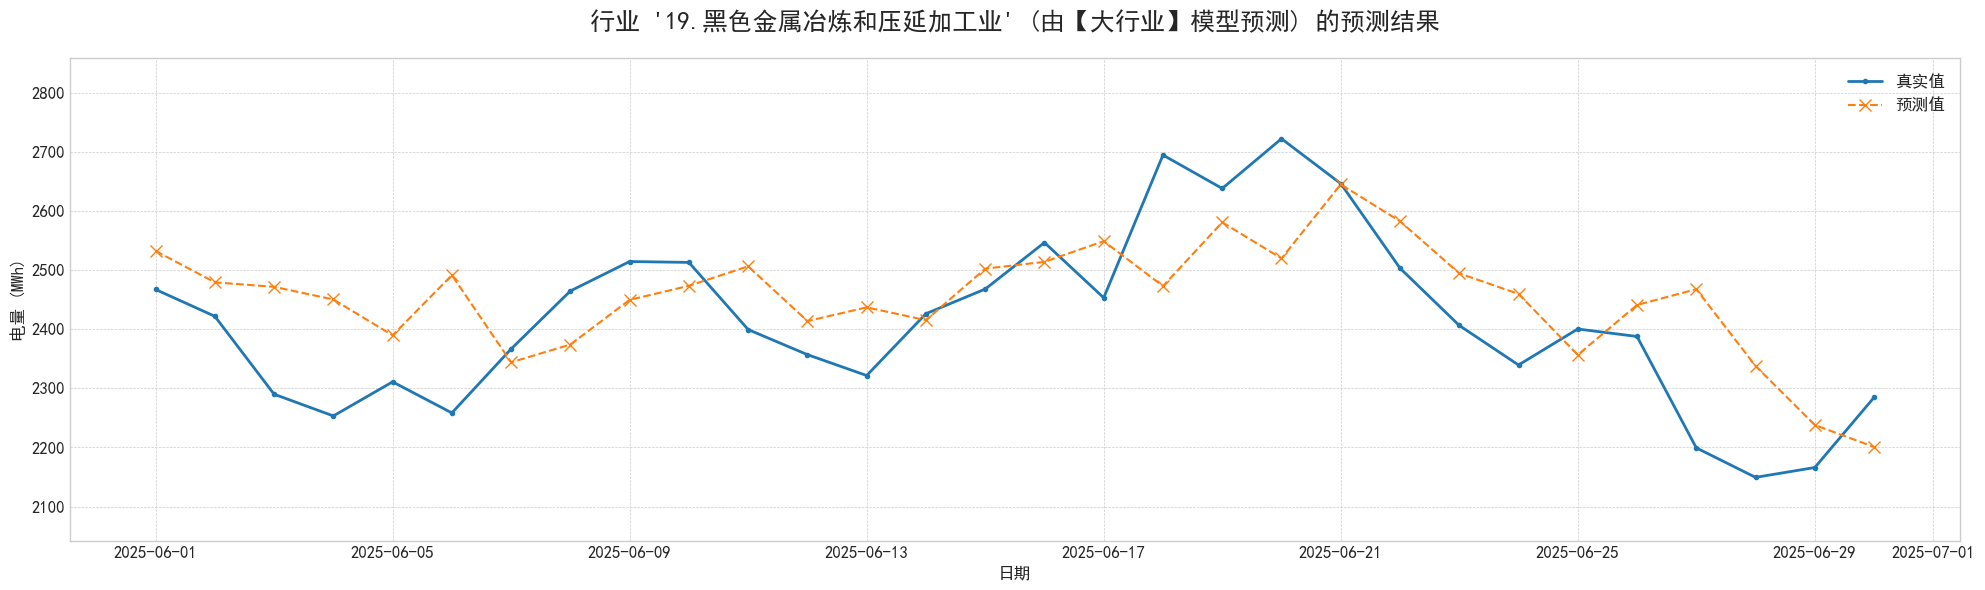

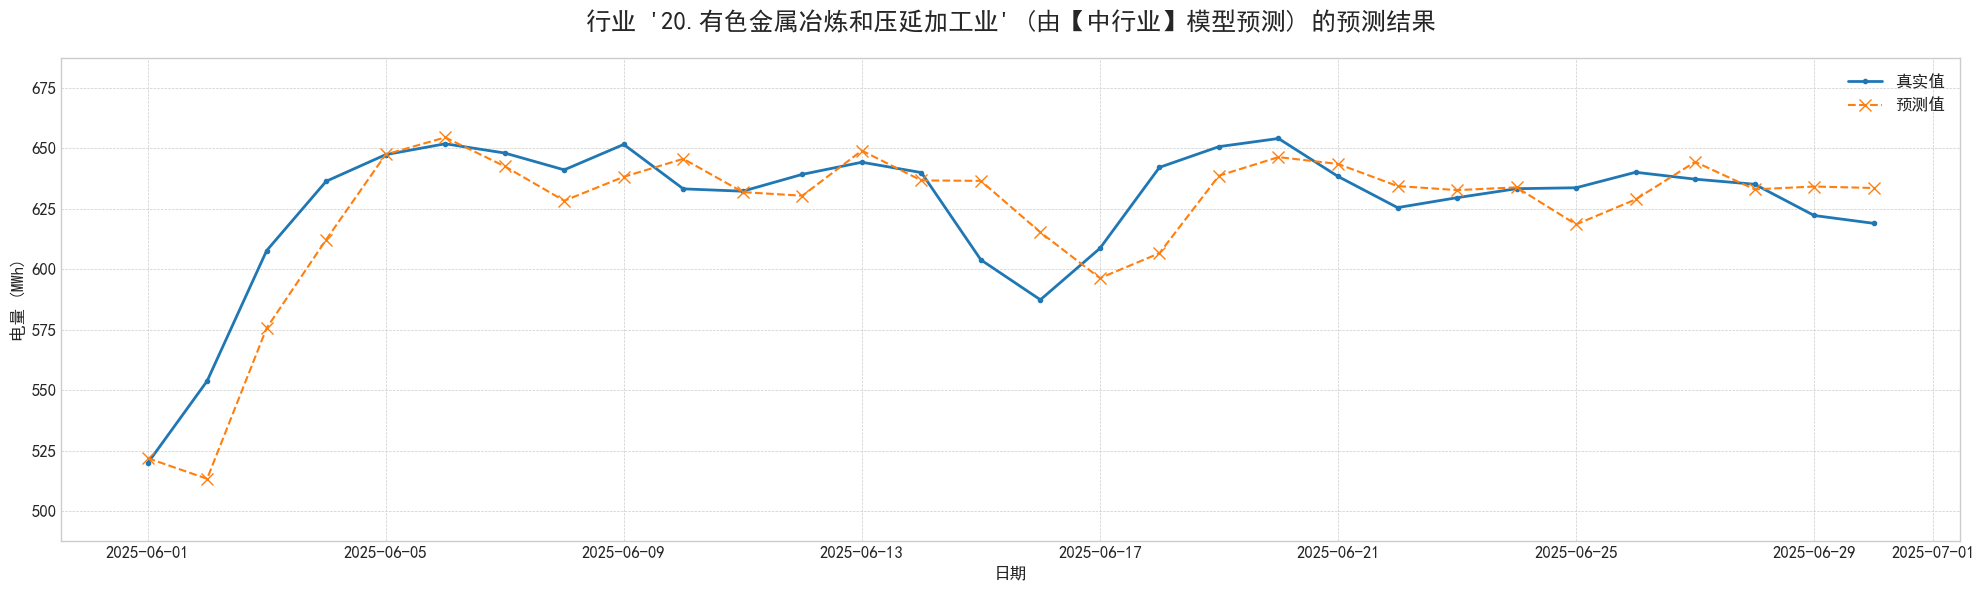

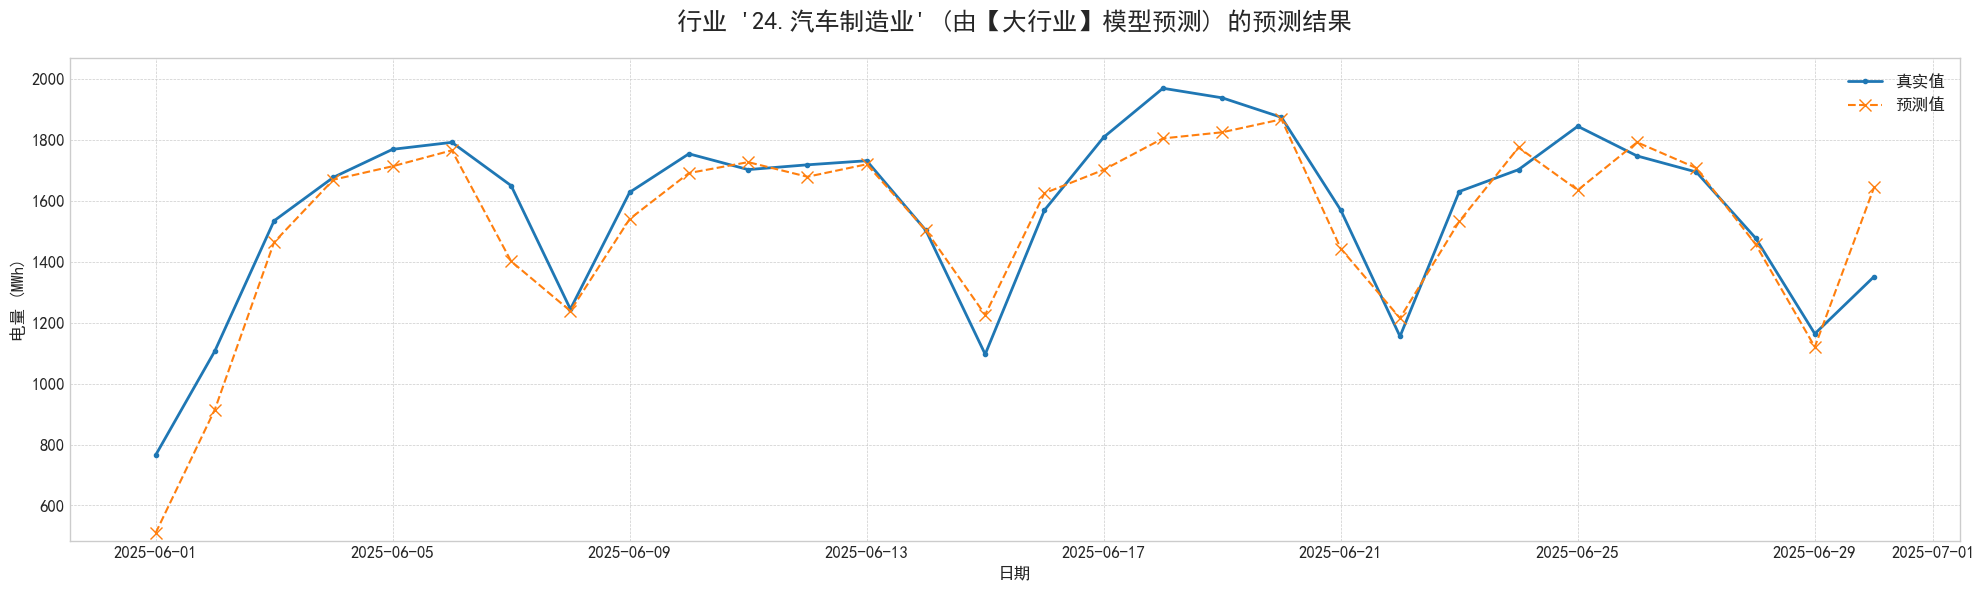

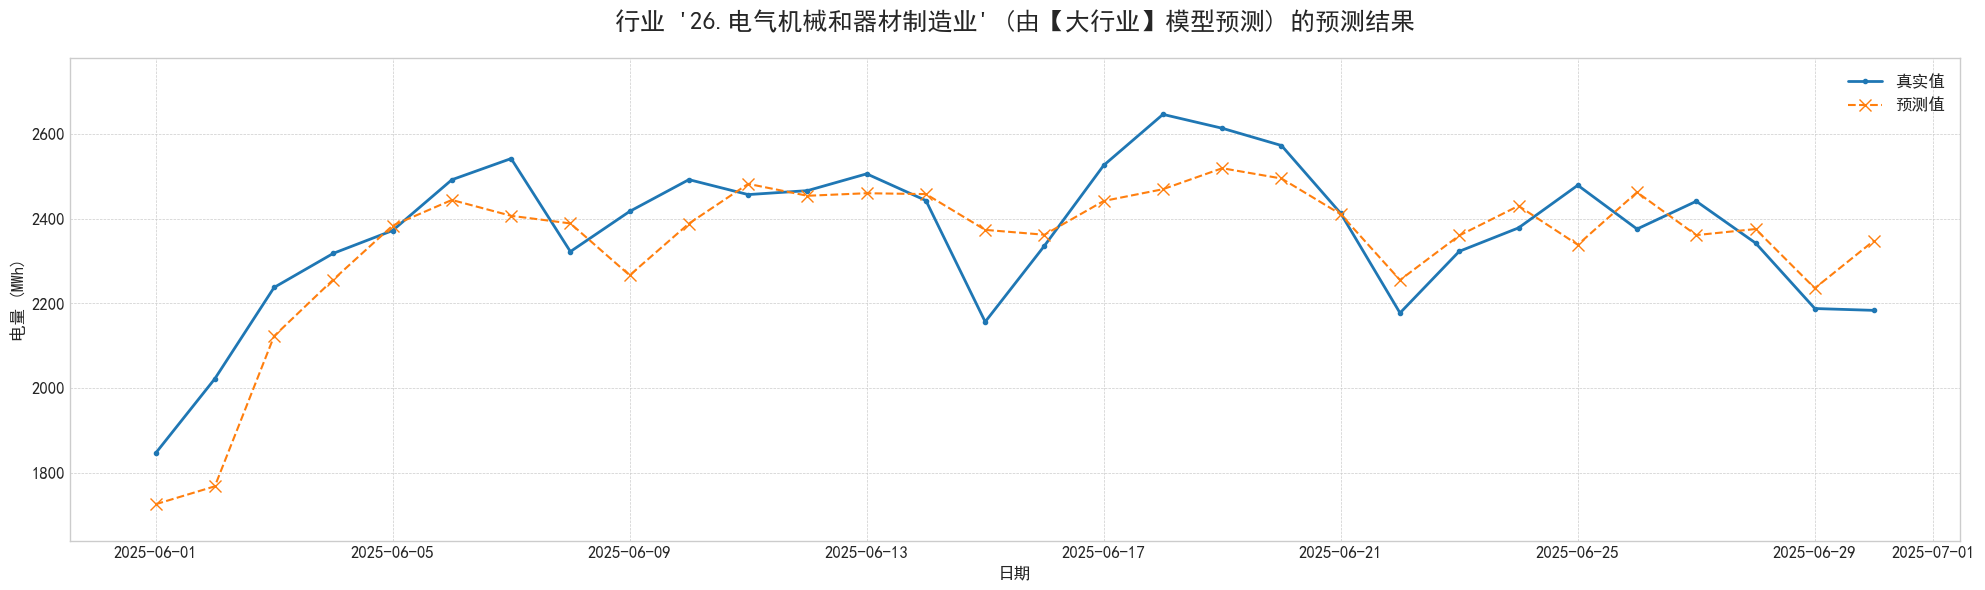

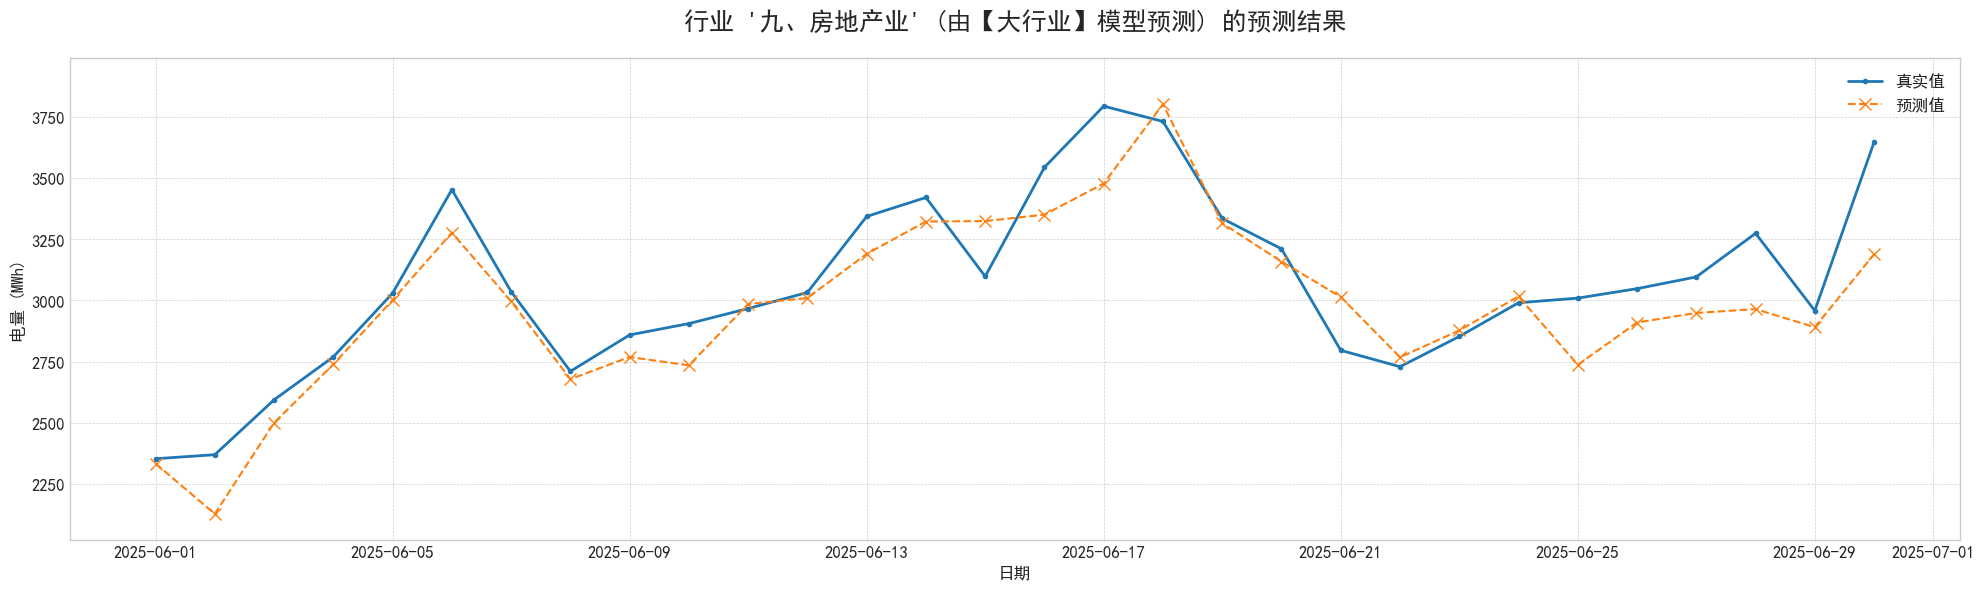

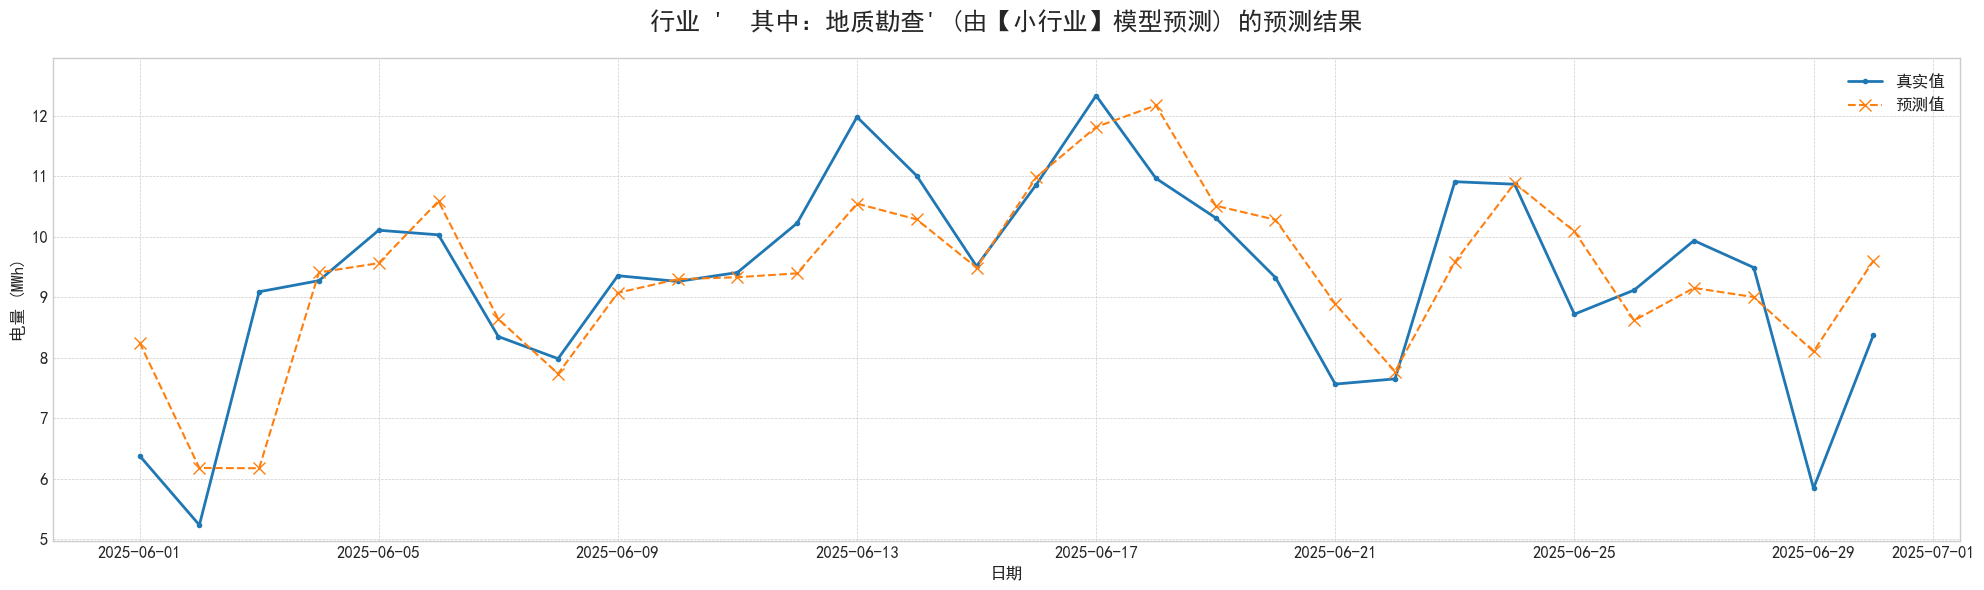

In [33]:
# --- 步骤：重点行业可视化评估 (针对分层模型结果) ---

# 确认包含所有预测结果的DataFrame 'final_test_df' 已经创建
if 'final_test_df' in locals() and not final_test_df.empty:

    # --- 1. 定义您重点关注的行业列表 ---
    key_industries = [
        "客户用电量",
        "    第二产业",
        "B、城乡居民生活用电合计",
        "14.化学原料和化学制品制造业",
        "15.医药制造业",
        "18.非金属矿物制品业",
        "19.黑色金属冶炼和压延加工业",
        "20.有色金属冶炼和压延加工业",
        "24.汽车制造业",
        "26.电气机械和器材制造业",
        "九、房地产业",
        "  其中：地质勘查"
        # 您可以按需添加或修改这个列表
    ]
    
    # 检查您关注的行业是否都存在于测试集中
    missing_industries = [ind for ind in key_industries if ind not in final_test_df['行业名称'].unique()]
    if missing_industries:
        print(f"\n警告：以下您关注的行业在测试集中不存在，将被忽略: {missing_industries}")
        key_industries = [ind for ind in key_industries if ind in final_test_df['行业名称'].unique()]

    # --- 2. 为重点行业计算详细的评估指标 ---
    print("\n" + "="*60)
    print("      重点行业性能评估报告 (分层模型版)")
    print("="*60)
    
    metrics_list = []
    for industry in key_industries:
        subset = final_test_df[final_test_df['行业名称'] == industry]
        if subset.empty: continue
            
        true_values = subset[TARGET]
        pred_values = subset['prediction']
        
        mae = mean_absolute_error(true_values, pred_values)
        rmse = np.sqrt(mean_squared_error(true_values, pred_values))
        
        non_zero_mask = true_values != 0
        mape = np.nan if not np.any(non_zero_mask) else mean_absolute_percentage_error(true_values[non_zero_mask], pred_values[non_zero_mask])
        
        avg_load = true_values.mean()

        metrics_list.append({
            '行业名称': industry,
            '所属模型层级': subset['tier'].iloc[0], # 【新】获取该行业所属的层级
            '平均绝对误差 (MAE)': mae,
            '均方根误差 (RMSE)': rmse,
            '平均绝对百分比误差 (MAPE)': mape,
            '日均用电量': avg_load,
            'MAE占日均比': mae / avg_load if avg_load != 0 else np.nan
        })

    df_key_metrics = pd.DataFrame(metrics_list).set_index('行业名称')
    
    # 打印格式化的表格
    pd.options.display.float_format = '{:,.2f}'.format
    print(df_key_metrics.to_string(formatters={
        '平均绝对百分比误差 (MAPE)': '{:,.2%}'.format,
        'MAE占日均比': '{:,.2%}'.format
    }))
    
    # --- 3. 为每个重点行业绘制高质量的预测对比图 ---
    print("\n--- 重点行业预测结果可视化 ---")
    
    for industry in key_industries:
        subset = final_test_df[final_test_df['行业名称'] == industry]
        if subset.empty: continue
            
        fig, ax = plt.subplots(figsize=(20, 6))
        
        ax.plot(subset['date'], subset[TARGET], label='真实值', marker='.', linestyle='-', linewidth=2)
        ax.plot(subset['date'], subset['prediction'], label='预测值', marker='x', linestyle='--', markersize=8)
        
        ax.set_title(f"行业 '{industry}' (由【{subset['tier'].iloc[0]}】模型预测) 的预测结果", fontsize=18, pad=20)
        ax.set_xlabel('日期', fontsize=12)
        ax.set_ylabel('电量 (MWh)', fontsize=12)
        
        ax.legend(fontsize=12, loc='upper right')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        y_min = min(subset[TARGET].min(), subset['prediction'].min())
        y_max = max(subset[TARGET].max(), subset['prediction'].max())
        ax.set_ylim(y_min * 0.95, y_max * 1.05)
        
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

else:
    print("错误：未能找到名为 'final_test_df' 的DataFrame。请确保您已经成功运行了模型分层的训练代码块。")

In [23]:
def predict_future(historical_data, days_to_predict, models, industry_tiers):
    """
    使用分层模型，对未来N天的所有行业电量进行递归预测。

    参数:
    - historical_data: DataFrame, 包含了到今天为止的所有历史数据 
                       (至少需要包含 'date', '行业名称', 'load_MWh', 以及所有天气特征列)。
    - days_to_predict: int, 您想要预测的未来天数 (例如: 8)。
    - models: dict, 存放了我们训练好的三个分层模型 {'大行业': model, ...}。
    - industry_tiers: DataFrame, 包含了每个行业的层级信息。

    返回:
    - DataFrame, 包含了未来N天所有行业的预测结果。
    """
    print(f"\n--- 开始预测未来 {days_to_predict} 天的电量 ---")
    
    # 1. 创建未来的日期范围
    last_known_date = historical_data['date'].max()
    future_dates = pd.date_range(start=last_known_date + pd.DateOffset(days=1), periods=days_to_predict, freq='D')
    
    # 2. 准备一个DataFrame来存放预测结果
    #    我们需要为每个行业都创建未来的行
    unique_industries = historical_data['行业名称'].unique()
    future_df = pd.DataFrame({
        'date': np.repeat(future_dates, len(unique_industries)),
        '行业名称': np.tile(unique_industries, days_to_predict)
    })

    # 3. 【关键】将历史数据和未来框架合并，方便进行递归特征计算
    #    我们只保留能用于计算滞后特征的最后一部分历史数据（例如，过去30天）
    history_for_features = historical_data[historical_data['date'] >= last_known_date - pd.DateOffset(days=30)].copy()
    full_df = pd.concat([history_for_features, future_df], ignore_index=True)

    # 4. 【占位符】为未来日期填充天气数据
    #    !!! 重要 !!!
    #    在这里，我们暂时使用最后一个已知日期的天气来“前向填充”未来的天气。
    #    当您收集到真实的未来天气预报后，需要在这里将其合并进来。
    weather_cols = [col for col in historical_data.columns if 'temp_' in col]
    full_df[weather_cols] = full_df[weather_cols].fillna(method='ffill')

    # 5. 【核心】开始逐日递归预测
    for current_date in future_dates:
        print(f"正在预测 {current_date.date()}...")
        
        # a) 为当前需要预测的日期创建完整的特征
        #    注意: 我们必须传入整个 full_df，以便特征工程函数能计算滞后值
        df_with_features = create_panel_features_with_holidays(full_df)
        
        # b) 筛选出我们正要预测的这一天的数据
        predict_day_data = df_with_features[df_with_features['date'] == current_date].copy()
        
        # c) 加入行业层级信息，以便我们知道该用哪个模型
        predict_day_data = predict_day_data.merge(industry_tiers[['tier']], on='行业名称', how='left')
        
        # d) 按层级进行预测
        for tier_name, model in models.items():
            # 找到属于这个层级的行业
            tier_industries_mask = (predict_day_data['tier'] == tier_name)
            
            if tier_industries_mask.any():
                # 准备特征矩阵
                X_pred = predict_day_data.loc[tier_industries_mask, model.feature_name_]
                
                # 进行预测
                predictions = model.predict(X_pred)
                
                # e) 【关键】将预测结果写回到我们的主DataFrame `full_df` 中
                #    这样，在预测下一天时，今天的预测值就可以作为昨天的“真实值”来计算滞后特征
                full_df.loc[
                    (full_df['date'] == current_date) & (full_df['行业名称'].isin(predict_day_data.loc[tier_industries_mask, '行业名称'])),
                    'load_MWh'
                ] = predictions

    # 6. 预测完成，筛选出未来的预测结果并返回
    final_predictions = full_df[full_df['date'] > last_known_date][['date', '行业名称', 'load_MWh']]
    final_predictions.rename(columns={'load_MWh': 'predicted_load_MWh'}, inplace=True)
    
    print("\n--- 预测完成！ ---")
    return final_predictions

In [24]:
# --- 假设我们用全部历史数据来进行一次模拟预测 ---
# df 是我们最开始加载的、清洗好的完整历史数据集
# final_models 是我们调优后训练好的模型字典
# industry_avg_load 是包含了行业层级信息的DataFrame

if 'df' in locals() and 'final_models' in locals() and 'industry_avg_load' in locals():
    # 调用预测函数，预测未来8天的电量
    future_forecast = predict_future(
        historical_data=df, 
        days_to_predict=8, 
        models=final_models, 
        industry_tiers=industry_avg_load
    )

    print("\n未来8天电量预测结果预览：")
    print(future_forecast.head(10))

    # (可选) 查看某个您关心的行业的未来预测
    print("\n查看'14.化学原料和化学制品制造业'的未来8天预测：")
    print(future_forecast[future_forecast['行业名称'] == '14.化学原料和化学制品制造业'])

else:
    print("错误：缺少必要的输入数据（df, final_models, 或 industry_avg_load），无法进行预测。")


--- 开始预测未来 8 天的电量 ---
正在预测 2025-07-01...


C:\Users\Joe-h\AppData\Local\Temp\ipykernel_37432\1422879653.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df[weather_cols] = full_df[weather_cols].fillna(method='ffill')


节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-02...
节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-03...
节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-04...
节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-05...
节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-06...
节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-07...
节假日特征创建预览：
Empty DataFrame
Columns: [date, dayofweek, is_holiday, is_weekend_norm, is_adj_workday, is_offday]
Index: []
正在预测 2025-07-08...
节假日特征创建预览：
Empty DataFrame
